<a href="https://colab.research.google.com/github/koya-namba/PyTorch_practice/blob/main/%E8%BB%A2%E7%A7%BB%E5%AD%A6%E7%BF%92(ResNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 転移学習

短いエポック数，少ないデータでも学習精度が高い．

今回は，ResNetを用いて，最後の層のみ学習を行う．

## ライブラリのインポート

モデルをインポートするときは，torchvisionからmodelsをインポート

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## データのダウンロード

ネットからデータをダウンロードして確認する．

In [3]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2021-06-28 02:12:22--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.36.99, 13.226.36.52, 13.226.36.38, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.36.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   101MB/s    in 0.4s    

2021-06-28 02:12:23 (101 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [4]:
!ls

hymenoptera_data.zip  sample_data


In [5]:
!unzip hymenoptera_data.zip

Archive:  hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/147318

In [6]:
!ls

hymenoptera_data  hymenoptera_data.zip	sample_data


In [7]:
!ls hymenoptera_data

train  val


In [8]:
!ls hymenoptera_data/train

ants  bees


In [12]:
!ls hymenoptera_data/train/ants

 0013035.jpg		     408393566_b5b694119b.jpg
 1030023514_aad5c608f9.jpg   424119020_6d57481dab.jpg
 1095476100_3906d8afde.jpg   424873399_47658a91fb.jpg
 1099452230_d1949d3250.jpg   450057712_771b3bfc91.jpg
 116570827_e9c126745d.jpg    45472593_bfd624f8dc.jpg
 1225872729_6f0856588f.jpg   459694881_ac657d3187.jpg
 1262877379_64fcada201.jpg   460372577_f2f6a8c9fc.jpg
 1269756697_0bce92cdab.jpg   460874319_0a45ab4d05.jpg
 1286984635_5119e80de1.jpg   466430434_4000737de9.jpg
 132478121_2a430adea2.jpg    470127037_513711fd21.jpg
 1360291657_dc248c5eea.jpg   474806473_ca6caab245.jpg
 1368913450_e146e2fb6d.jpg   475961153_b8c13fd405.jpg
 1473187633_63ccaacea6.jpg   484293231_e53cfc0c89.jpg
 148715752_302c84f5a4.jpg    49375974_e28ba6f17e.jpg
 1489674356_09d48dde0a.jpg   506249802_207cd979b4.jpg
 149244013_c529578289.jpg    506249836_717b73f540.jpg
 150801003_3390b73135.jpg    512164029_c0a66b8498.jpg
 150801171_cd86f17ed8.jpg    512863248_43c8ce579b.jpg
 154124431_65460430f2.jpg    518773929_7

データのサイズがバラバラのときは，transforms.Resizeで合わせる．

In [9]:
transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
])

フォルダからデータを持ってくるときは，datasets.ImageFolderを用いる．

データの入っているフォルダの1個上のデータを持ってくる．

このとき，データの入っているフォルダはラベル名であることに注意．

In [11]:
train_dataset = datasets.ImageFolder('./hymenoptera_data/train', transform=transform)

### ミニバッチの作成と画像の確認

In [14]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [15]:
data_iter = iter(train_loader)

In [16]:
imgs, labels = data_iter.next()

In [20]:
labels

tensor([0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1])

In [21]:
imgs.size()

torch.Size([32, 3, 224, 224])

In [22]:
img = imgs[0]

In [23]:
img_permute = img.permute(1, 2, 0)

In [24]:
img_permute = 0.5 * img_permute + 0.5

In [25]:
img_permute = np.clip(img_permute, 0, 1)

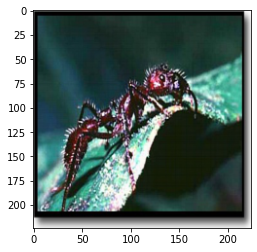

In [26]:
plt.imshow(img_permute)

## モデルの構築

pretrained=Trueで学習済みを持ってくることができる．

In [28]:
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [29]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

勾配の計算を行わなくていいように以下を設定する．

In [31]:
for param in model.parameters():
    param.requires_grad = False

1000クラス分類から2クラス分類に変更するため以下を設定する．

In [32]:
model.fc = nn.Linear(512, 2)

In [33]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## 学習

In [34]:
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

optimizerの引数に渡すのは，学習を行うパラメータのみ！


In [35]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [36]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    losses.append(running_loss)
    accs.append(running_acc)
    print('epoch: {}, loss: {}, acc: {}'.format(epoch, running_loss, running_acc))

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


epoch: 0, loss: 0.6970762088894844, acc: 0.574999988079071
epoch: 1, loss: 0.5054256916046143, acc: 0.762499988079071
epoch: 2, loss: 0.36772090941667557, acc: 0.887499988079071
epoch: 3, loss: 0.30977390334010124, acc: 0.917187511920929
epoch: 4, loss: 0.2699925433844328, acc: 0.928906261920929
epoch: 5, loss: 0.2346977647393942, acc: 0.9453125
epoch: 6, loss: 0.2116454914212227, acc: 0.9390624761581421
epoch: 7, loss: 0.18063270021229982, acc: 0.96875
epoch: 8, loss: 0.18802898656576872, acc: 0.940625011920929
epoch: 9, loss: 0.15076382737606764, acc: 0.96875
epoch: 10, loss: 0.16297168470919132, acc: 0.9507812261581421
epoch: 11, loss: 0.1439945437014103, acc: 0.96875
epoch: 12, loss: 0.14477193169295788, acc: 0.96875
epoch: 13, loss: 0.12952050287276506, acc: 0.9820312261581421
epoch: 14, loss: 0.1315410751849413, acc: 0.9765625


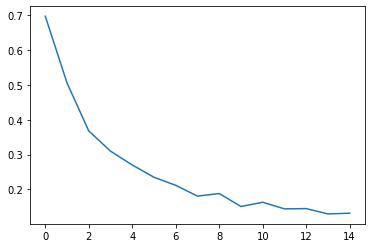

In [37]:
plt.plot(losses)

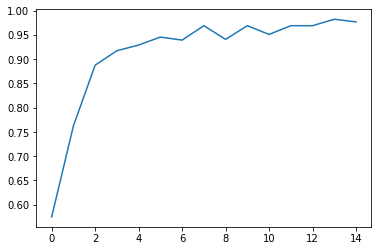

In [38]:
plt.plot(accs)

## まとめ

### ライブラリのインポート

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

### デバイスの確認

In [40]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### データをダウンロード

In [ ]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip

### データの前処理

In [41]:
transform = transforms.Compose([
                                transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
])

In [42]:
train_dataset = datasets.ImageFolder('./hymenoptera_data/train', transform=transform)

In [43]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

### モデルの構築

In [44]:
model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 2)

### 学習

In [45]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [46]:
num_epochs = 15
losses = []
accs = []
for epoch in range(num_epochs):
    running_loss = 0.0
    running_acc = 0.0
    for imgs, labels in train_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, labels)
        running_loss += loss.item()
        pred = torch.argmax(output, dim=1)
        running_acc += torch.mean(pred.eq(labels).float())
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader)
    running_acc /= len(train_loader)
    losses.append(running_loss)
    accs.append(running_acc)
    print('epoch: {}, loss: {}, acc: {}'.format(epoch, running_loss, running_acc))

epoch: 0, loss: 0.6907728537917137, acc: 0.606249988079071
epoch: 1, loss: 0.47817037254571915, acc: 0.823437511920929
epoch: 2, loss: 0.364187628030777, acc: 0.8921874761581421
epoch: 3, loss: 0.29997073486447334, acc: 0.9140625
epoch: 4, loss: 0.2758801653981209, acc: 0.9078124761581421
epoch: 5, loss: 0.25617294386029243, acc: 0.9312499761581421
epoch: 6, loss: 0.2352852299809456, acc: 0.9320312738418579
epoch: 7, loss: 0.24126348085701466, acc: 0.94140625
epoch: 8, loss: 0.16724400036036968, acc: 0.95703125
epoch: 9, loss: 0.1796296602115035, acc: 0.9390624761581421
epoch: 10, loss: 0.1907777627930045, acc: 0.9429687261581421
epoch: 11, loss: 0.1523679429665208, acc: 0.953906238079071
epoch: 12, loss: 0.14592862129211426, acc: 0.95703125
epoch: 13, loss: 0.14966071397066116, acc: 0.9585937261581421
epoch: 14, loss: 0.14265596866607666, acc: 0.9703124761581421


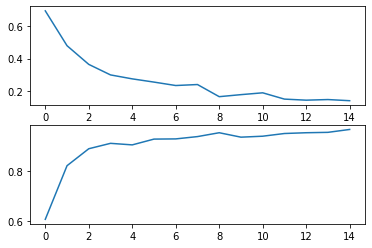

In [47]:
plt.subplot(2, 1, 1)
plt.plot(losses)

plt.subplot(2, 1, 2)
plt.plot(accs)